# Main notebook for simulation experiments

## Imports

In [53]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import coclusterSVD as ccSVD
import bicluster as bc
import submatrix as sm
import importlib 

def generate(seed, num_bicluster, num_pool, M, N, m, n):
    # psedo random vector with fixed seed, ori(0), ori(1), ... ori(num_bicluster-1)
    ori = np.random.RandomState(seed=seed).rand(num_bicluster, num_pool)

    # scale = np.random.RandomState(seed+2).rand(num_bicluster)

    # p is a list, p[i] is a n[i]-length vector, as the base of bicluster i
    p = []
    for i in range(num_bicluster):
        p.append(ori[i][:n[i]])

    for i in range(num_bicluster):
        assert len(p[i]) == n[i]

    A = np.zeros((M, N))

    # A(0:n(0), 0:m(0)) = p(0)
    # A(n(0):n(0)+n(1), 0:m(1)) = p(1)
    # ...

    startx = starty = 0
    label_matrix = np.zeros((M, N)) # value is the label of bicluster
    for i in range(num_bicluster):
        for j in range(m[i]):
            A[startx:startx+n[i], starty+j] = p[i] * np.random.RandomState(i*2000 + j).rand()
            label_matrix[startx:startx+n[i], starty+j] = i
        startx += n[i]
        starty += m[i]

    # show A as a heatmap
    # plt.imshow(A, cmap='hot', interpolation='nearest')
    # plt.show()

    # permutation of M and N
    permx = np.random.RandomState(seed).permutation(M)
    permy = np.random.RandomState(seed+1).permutation(N)

    # print permx and permy
    # print('permx: ', permx)
    # print('permy: ', permy)

    # permute A
    B = A[permx, :]
    B = B[:, permy]

    label_matrix = label_matrix[permx, :]
    label_matrix = label_matrix[:, permy]

    # B = A + rand * 0.1 * average(A)
    # B = B + np.random.RandomState(seed).rand(M, N) * 0.01 * np.mean(A)

    # show B as a heatmap

    return B, permx, permy, A, label_matrix


## Generate Big Matrix ($M \times N$)

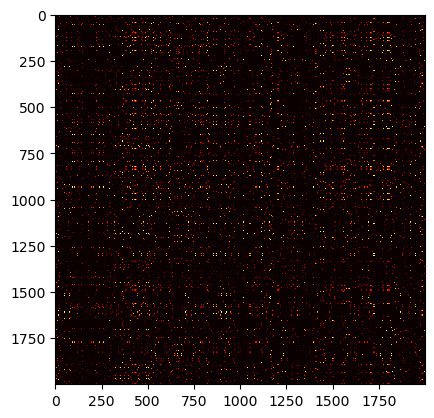

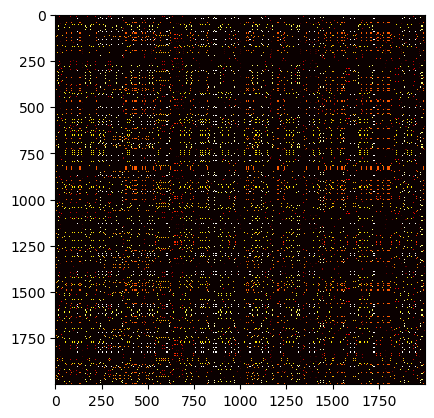

In [54]:
seed = 42
num_pool = 200 # as random pool for bases of biclusters
# num_upper_bound = 20 # upper bound of number of biclusters
# num_bicluster = np.random.RandomState(seed+1).randint(1, num_upper_bound, 1)[0] # number of biclusters
num_bicluster = 15
# random n(0) n(1) n(2) ... n(num_bicluster-1) as the length of each bicluster base vector
n = np.random.RandomState(seed=seed).randint(
    num_pool/5, num_pool, num_bicluster)


# m is the height of biclusters
m = np.random.RandomState(
    seed=seed+1).randint(num_pool/5, num_pool, num_bicluster)
# m = np.ones(num_bicluster, dtype=int) * 1000
# n = np.ones(num_bicluster, dtype=int) * 1000

M = 2000
N = 2000
B, permx, permy, A, labelMatrix = generate(
        seed=seed, num_pool=num_pool, num_bicluster=num_bicluster, M=M, N=N, m=m, n=n
    )

# print('permx: ', permx)
# print('permy: ', permy)

plt.imshow(B, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(labelMatrix, cmap='hot', interpolation='nearest')
plt.show()

## Generate submatrix list (and labelMatList)

(500, 500)


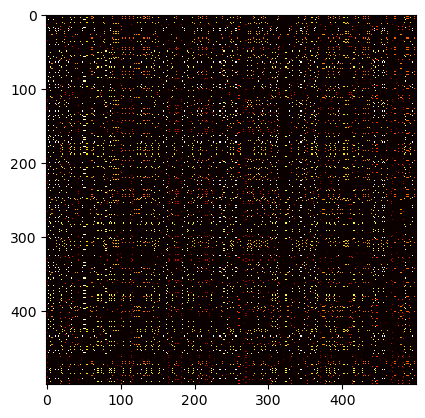

In [55]:
partition : int = 4

sizex = M // partition
sizey = N // partition

importlib.reload(sm)
subMatList = []
labelMatList = []
for i in range(partition):
    for j in range(partition):
        subMatList.append(sm.submatrix(B[i*sizex:(i+1)*sizex, j*sizey:(j+1)*sizey], i*sizex, j*sizey))
        labelMatList.append(sm.submatrix(labelMatrix[i*sizex:(i+1)*sizex, j*sizey:(j+1)*sizey], i*sizex, j*sizey))

print(labelMatList[0].matrix.shape)
plt.imshow(labelMatList[0].matrix, cmap='hot', interpolation='nearest')
plt.show()


## Coclustering on each submatrix

In [56]:
importlib.reload(ccSVD)
importlib.reload(bc)
from joblib import Parallel, delayed
# ans = ccSVD.coclusterAtom(testB, tor=10e-2, k = 15)

biclusterList = []
# for item in subMatList:
# for item in labelMatList:
#     # concat the biclusterList
#     biclusterList += ccSVD.coclusterAtom(X=item, tor=10e-5, k = 15, M=M, N=N)
result = Parallel(n_jobs=-1)(delayed(ccSVD.coclusterAtom)(X=item, tor=10e-5, k = 15, M=M, N=N) for item in subMatList)
print('result type: ', type(result))

# print('biclusterList.length: ', len(biclusterList))

biclusterList.length:  10


In [57]:
# while biclusterList not empty
from coclusterSVD import isBiclusterIntersectGeneral
importlib.reload(ccSVD)
importlib.reload(bc)


count = 0
flag = True # if flag is True, then the item is not merged
while len(biclusterList) > 0:
    count += 1
    item : bc.bicluster = biclusterList.pop(0)
    for item_c in biclusterList:
        # concat the biclusterList
        # if ccSVD.isBiclusterIntersectGeneral(bc1=item, bc2=item_c):
        if True:
            # newRowIdx is OR(rowIdx, rowIdx_c)
            # e.g. rowIdx = [True, False, True], rowIdx_c = [False, True, True], newRowIdx = [True, True, True]
            newRowIdx = np.logical_or(item.row_idx, item_c.row_idx)
            newColIdx = np.logical_or(item.col_idx, item_c.col_idx)
            newScore = ccSVD.score(B, newRowIdx, newColIdx)
            print('newScore: ', newScore)
            # if newScore < item.score + item_c.score or newScore < 0.01:
            if newScore < item.score + item_c.score or newScore < 0.001:
                # replace item_c with new bicluster
                biclusterList.remove(item_c)
                biclusterList.append(bc.bicluster(newRowIdx, newColIdx, newScore))
                count = 0
                flag = False
                break
    if flag:
        biclusterList.append(item)
        flag = True
    if count > 2 * len(biclusterList):
        break
    
print('biclusterList.length: ', len(biclusterList))
            

newScore:  0.21404278527109455
newScore:  0.2252077785554375
newScore:  0.22568597715570815
newScore:  0.6302145953127378
newScore:  0.6747332960856006
newScore:  0.22579996304036054
newScore:  0.23284217504773863
newScore:  0.5293306645490597
newScore:  0.6696851909792305
newScore:  0.18627436007466225
newScore:  0.20330679583367584
newScore:  0.6186415404033733
newScore:  0.6879786759206905
newScore:  0.26996659252402855
newScore:  0.25174306748782715
newScore:  0.58065028149954
newScore:  0.6667721238785431
newScore:  0.19790955751714157
newScore:  0.24184631658649247
newScore:  0.672796235952203
newScore:  0.6858510276245411
newScore:  0.2539200988055663
newScore:  0.2399396842156184
newScore:  0.5066956174307493
newScore:  0.6648093049031554
newScore:  0.21436807681589387
newScore:  0.20122054614116602
newScore:  0.7105432991698386
newScore:  0.6478838960664379
newScore:  0.29505980585740565
newScore:  0.24206298016309113
newScore:  0.4784204622391375
newScore:  0.6454893998987519

In [58]:
# print all length of biclusters
ite = 0
for item in biclusterList:
    print('ite: ', ite)
    print('row length: ', np.sum(item.row_idx))
    # print('row_size: ', item.row_idx.size)
    print('col length: ', np.sum(item.col_idx))
    # print('col_size: ', item.col_idx.size)
    print('score: ', item.score)
    # print('row_idx: ', item.row_idx)
    # print('col_idx: ', item.col_idx)
    print('------------------')
    ite += 1
    

ite:  0
row length:  227
col length:  2
score:  0.0
------------------
ite:  1
row length:  38
col length:  2
score:  0.0
------------------
ite:  2
row length:  12
col length:  2
score:  0.0
------------------
ite:  3
row length:  2
col length:  117
score:  0.0
------------------
ite:  4
row length:  2
col length:  370
score:  0.0
------------------
ite:  5
row length:  16
col length:  2
score:  0.0
------------------
ite:  6
row length:  461
col length:  2
score:  0.0
------------------
ite:  7
row length:  2
col length:  7
score:  0.0
------------------
ite:  8
row length:  2
col length:  475
score:  0.0
------------------
ite:  9
row length:  200
col length:  2
score:  0.0
------------------


In [ ]:
# cluster1index = permx
testA = A[0:n[0], 0:m[0]]

# testI is all true with shape (n[0],)
# testJ is all true with shape (m[0],)
testI = np.ones(n[0], dtype=bool)
testJ = np.ones(m[0], dtype=bool)

testScore = ccSVD.score(testA, testI, testJ)
print('testScore: ', testScore)

testScore:  0.0


In [ ]:
# m[0]
# n[0]
print('m[0]: ', m[0])
print('n[0]: ', n[0])

# find range(0, n[0]) from permx and save it to IDX_I_one
# find range(0, m[0]) from permy and save it to IDX_J_one

IDX_I_one = permx[0:n[0]]
IDX_J_one = permy[0:m[0]]

# show limited to M // partition * N // partition submatrix
IDX_I_one = IDX_I_one[IDX_I_one < M // partition]
IDX_J_one = IDX_J_one[IDX_J_one < N // partition]

print('IDX_I_one: ', IDX_I_one)
print('IDX_J_one: ', IDX_J_one)

m[0]:  108
n[0]:  142
IDX_I_one:  [353  65  56 374 275 128  99  29 450 254 124 251  70 247 212 361 111 383
 324 368  69 478 281 210 297 429 239 256 382 352 494 393 464 366 306]
IDX_J_one:  [305 454 497  91 131 495 384 431 112  82  23  72 404 427 270 195  68]


## Work on one submatrix

### Get the small matrix

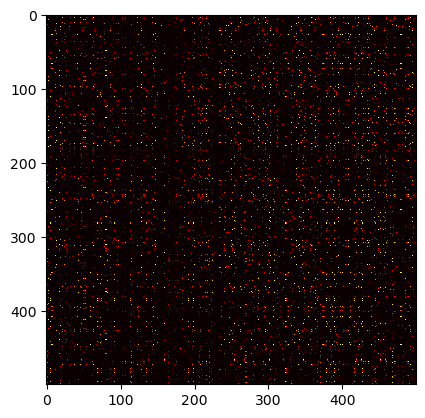

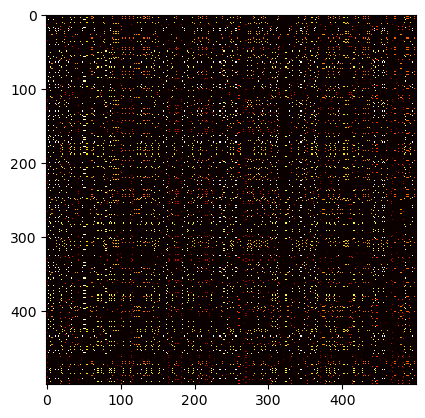

In [5]:
testB = subMatList[0]
testB_label = labelMatList[0]

plt.imshow(testB.matrix, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(testB_label.matrix, cmap='hot', interpolation='nearest')
plt.show()

In [13]:
ans = ccSVD.coclusterAtom(testB, tor=10e-2, k = 15, M=M, N=N)
print('ans: ', ans)

ans:  [bicluster(row_idx=array([ True,  True,  True, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=-2.220446049250313e-16), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([ True,  True, False, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0), bicluster(row_idx=array([False, False, False, ..., False, False, False]), 

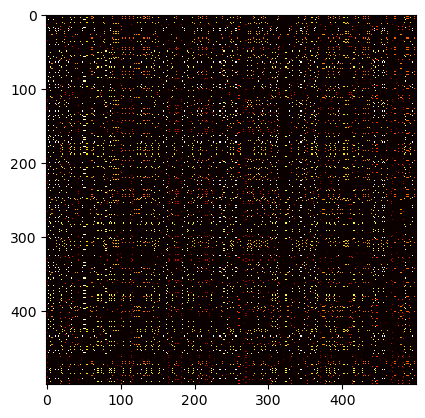

In [13]:
importlib.reload(ccSVD)
importlib.reload(bc)

# imshow B
plt.imshow(labelMatList[0].matrix, cmap='hot', interpolation='nearest')

U, S, Vh = np.linalg.svd(labelMatList[0].matrix, full_matrices=False)
C = np.dot(U, np.diag(S))

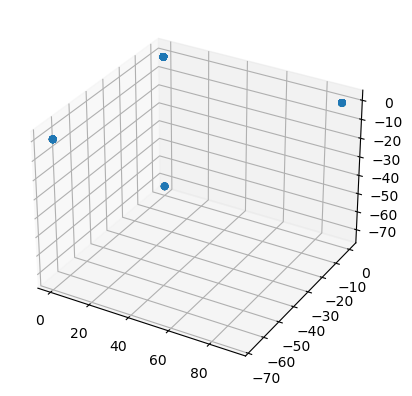

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x, y, z = C[:, 0], C[:, 1], C[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()


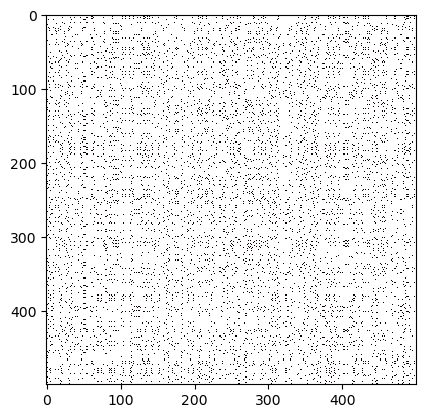

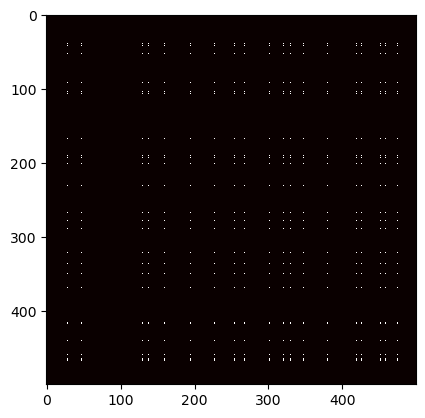

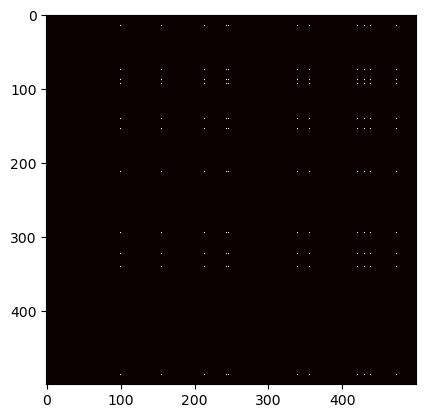

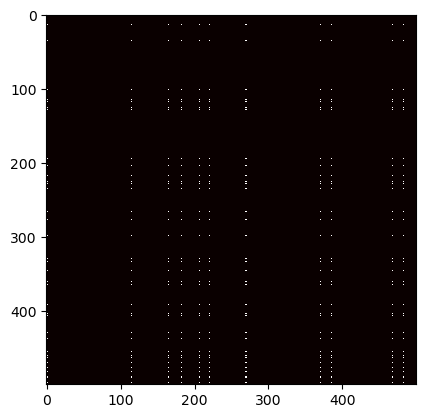

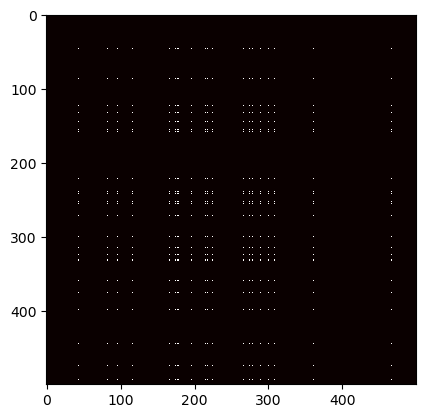

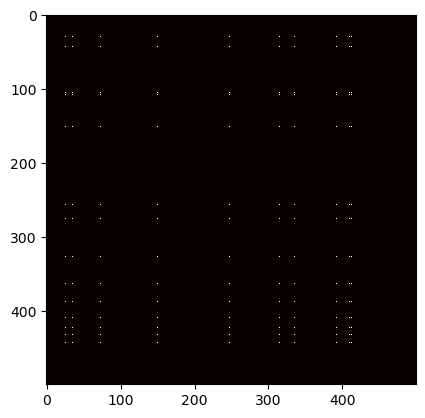

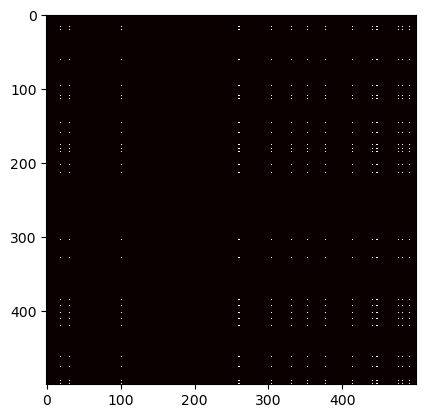

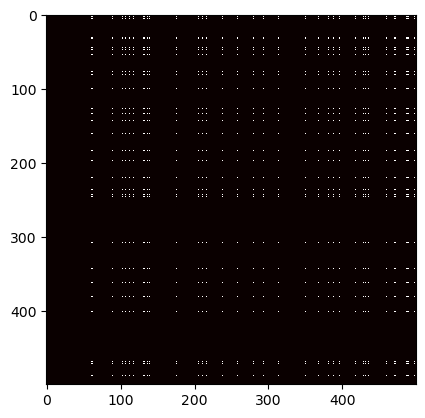

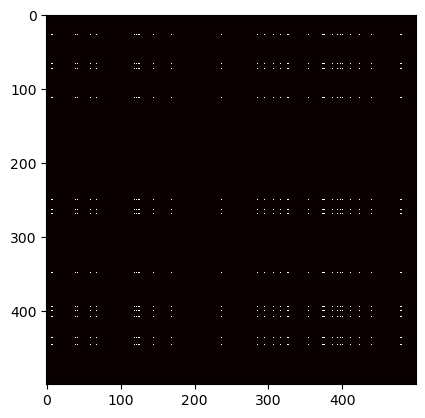

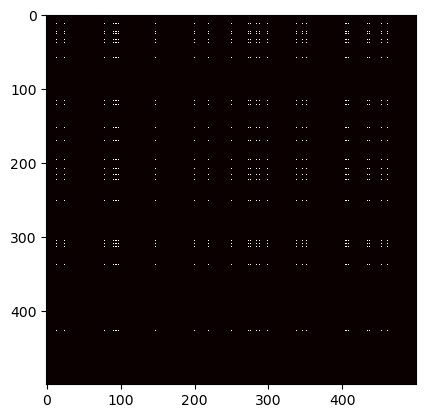

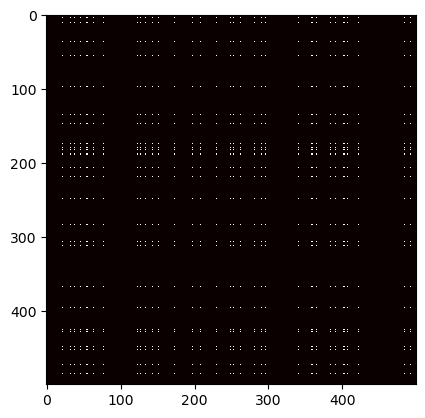

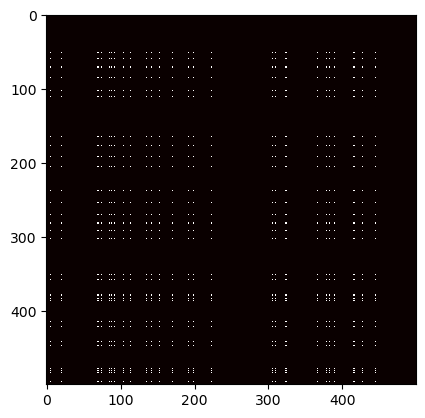

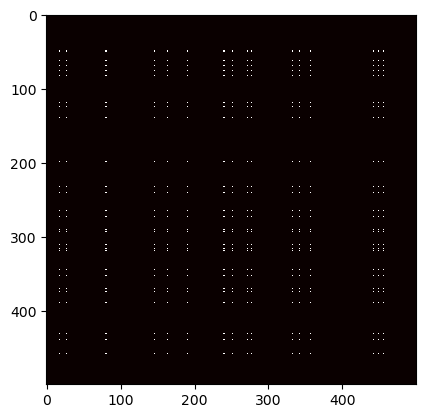

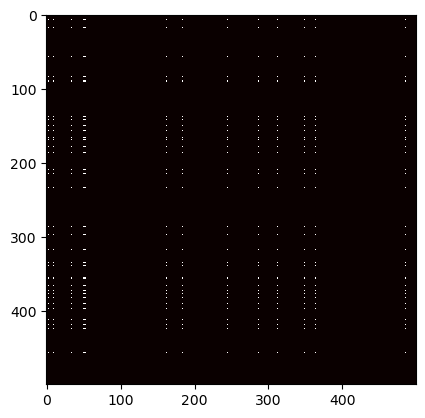

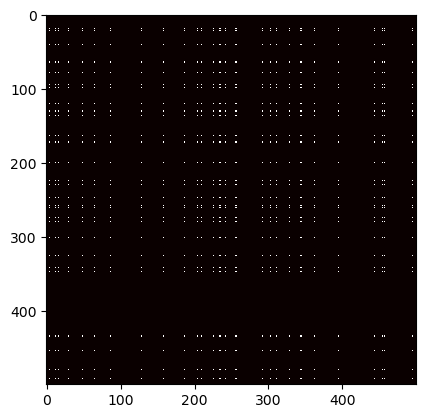

row length:  5
col length:  2
score:  0.0
------------------
row length:  402
col length:  2
score:  0.0
------------------
row length:  2
col length:  459
score:  0.0
------------------
row length:  2
col length:  3
score:  0.0
------------------
row length:  2
col length:  2
score:  -2.220446049250313e-16
------------------
row length:  2
col length:  25
score:  0.0
------------------
row length:  2
col length:  459
score:  0.0
------------------
row length:  2
col length:  3
score:  0.0
------------------
row length:  2
col length:  2
score:  -2.220446049250313e-16
------------------
row length:  2
col length:  25
score:  0.0
------------------
row length:  57
col length:  2
score:  0.0
------------------
row length:  23
col length:  2
score:  0.0
------------------


In [30]:
testLabelMat = labelMatList[0]
ansBiList = ccSVD.coclusterAtom(testLabelMat, tor=10e-2, k = 15, M=M, N=N)

# show testLabelMat.matrix == i
for i in range(num_bicluster):
    plt.imshow(testLabelMat.matrix == i, cmap='hot', interpolation='nearest')
    plt.show()


In [33]:
# find testLabelMat.matrix == 1
rowIndOne = np.where(testLabelMat.matrix == 1)[0]
colIndOne = np.where(testLabelMat.matrix == 1)[1]

print('rowIndOne.shape: ', rowIndOne.shape)
print('colIndOne.shape: ', colIndOne.shape)

# matBoolOne means testLabelMat.matrix == 1
matBoolOne = testLabelMat.matrix == 1
rowBoolOne = np.any(matBoolOne, axis=1)
colBoolOne = np.any(matBoolOne, axis=0)

scoreTestOne = ccSVD.score(testLabelMat.matrix, rowBoolOne, colBoolOne)
print('scoreTestOne: ', scoreTestOne)

# show ansBiList
# for item in ansBiList:
#     print('row length: ', np.sum(item.row_idx))
#     print('col length: ', np.sum(item.col_idx))
#     print('score: ', item.score)
#     print('------------------')


rowIndOne.shape:  (864,)
colIndOne.shape:  (864,)
scoreTestOne:  0.7913966559827197


In [51]:
# testPure is 100x100 one matrix
importlib.reload(ccSVD)
testPure = np.ones((100, 100))
rowBoolPure = np.ones(100, dtype=bool)
colBoolPure = np.ones(100, dtype=bool)

scoreTestPure = ccSVD.score(testPure, rowBoolPure, colBoolPure)
print('scoreTestPure: ', scoreTestPure)

scoreTestPure:  0.0
